# Stochastic gradient descent

In [601]:
import numpy as np
import pandas as pd
import random
from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.othermod.betareg import BetaModel
from statsmodels.genmod.families.links import Identity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma
from scipy.special import digamma
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

## Классы стоперов, градиентов и регрессоров

In [602]:
class Stoper:
    """
    Базовый класс для любого стопера.
    """

    def __init__(self):
        pass

    def stop(self, x: np.array) -> bool:
        """
        Функция которая возвращает True, если выполнено условие для остановки,
        иначе False.

        Параметры:
        ----------
                x (np.array): точка, в которой требуется проверить критерий.

        Возвращаемое значение:
        ----------------------
            bool_stop (bool): True, если критерий остановки выполнен,
            False - иначе.
        """
        return True


class StoperK(Stoper):
    """
    Класс стопера, критерием которого является количество итераций.
    """

    def __init__(self, max_step: int = 100):
        """
        Инициализирует класс итерирующего стопера.

        Параметры:
        ----------
            max_step (int): максимальное количество итераций.
        """
        super().__init__()
        self.max_step = max_step
        self.k = 0

    def stop(self, x: np.array) -> bool:
        """
        Функция которая возвращает True, если выполнено условие для остановки,
        иначе False.

        Параметры:
        ----------
            x (np.array): точка, в которой требуется проверить критерий.

        Возвращаемое значение:
        ----------------------
            bool_stop (bool): True, если критерий остановки выполнен,
            False - иначе.
        """
        if self.k >= self.max_step:
            return True

        self.k += 1

        return False


class StoperPoint(Stoper):
    """
    Класс стопера, критерием которого является
    норма разности нынешней и прошлой точки.
    """

    def __init__(self, epsilon: float = 1e-3, max_step: int = 1000000):
        """
        Инициализирует класс итерирующего стопера.

        Параметры:
        ----------
            epsilon (float): условие на норму разности.

            max_step (int): максимальное количество итераций.
        """
        super().__init__()
        self.max_step = max_step
        self.epsilon = epsilon
        self.k = 0

    def stop(self, x: np.array) -> bool:
        """
        Функция которая возвращает True, если выполнено условие для остановки,
        иначе False.

        Параметры:
        ----------
            x (np.array): точка, в которой требуется проверить критерий.

        Возвращаемое значение:
        ----------------------
            bool_stop (bool): True, если критерий остановки выполнен,
            False - иначе.
        """
        if self.k >= self.max_step:
            return True

        self.k += 1

        if self.k == 1:
            self.back_x = x
        else:
            norm = np.linalg.norm(x - self.back_x)
            self.back_x = x

            return not norm >= self.epsilon

        return False


class Direction:
    """
    Базовый класс для направления по которому идёт градиентный спуск.
    """

    def __init__(self, size_param: int):
        """
        Инициализирует класс направления.

        Параметры:
        ----------
            size_param (int): размерность оптимизируемого значения.
        """
        self.size_param = size_param

    def get_direction(self, x: np.array):
        """
        Возвращает направление для градиентного спуска.

        Параметры:направление
        ----------
            x (np.array): точка (вектор), в которой требуется найти направление.

        Возвращаемое значение:
        ----------------------
            direction (np.array): вектор направления.
        """
        return np.zeros(self.size)


def simple_derivative(x: np.array, X: np.array, y: np.array, size: int):
    """
    Производная для метода наименьших квадратов.

    Параметры:
    ----------
        x (np.array): точка (вектор), в которой требуется найти производную.

        X (np.array): матрица регрессоров.

        y (np.array): вектор таргетов.

        size (int): размер выборки.
    """
    return 2 / size * X.T.dot(X.dot(x) - y)


def log_likelyhood_simple(x: np.array, X: np.array, y: np.array):
    """
    Функция правдоподобия для обычной линейной регрессии.

    Параметры:
    ----------
        x (np.array): точка (вектор), в которой требуется найти функцию правдоподобия.

        X (np.array): матрица регрессоров.

        y (np.array): вектор таргетов.
    """
    errors = y - X.dot(x)
    sigma = np.var(errors)

    return -np.sum(0.5 * np.log(2 * np.pi) + np.log(sigma) + errors**2 / (2 * sigma**2))


class DirectionData(Direction):
    """
    Класс направления для задачи линейной регрессии.
    """

    def __init__(self, X: np.array, y: np.array, derivative, alpha: float = 1e-3):
        """
        Инициализирует класс направления для задачи линейной регрессии.

        Параметры:
        ----------
            X (np.array): матрица регрессоров.

            y (np.array): вектор таргетов.

            derivative (function): функция которая по матрице данных, таргету и точке
            возвращает направление для градиентного спуска.

            alpha (float): шаг градиентного спуска.
        """
        self.X = X
        self.y = y
        self.derivative = derivative
        self.alpha = alpha
        self.size = y.shape[0]
        self.size_param = X.shape[1]

    def get_direction(self, x: np.array):
        """
        Возвращает направление для градиентного спуска.

        Параметры:направление
        ----------
            x (np.array): точка (вектор), в которой требуется найти направление.

        Возвращаемое значение:
        ----------------------
            direction (np.array): вектор направления.
        """
        return -self.alpha * self.derivative(x, self.X, self.y, self.size)


class DirectionDataStochastic(DirectionData):
    """
    Класс направления для задачи линейной регрессии со стохастическим методом.
    """

    def __init__(
        self,
        X: np.array,
        y: np.array,
        derivative,
        alpha: float = 1e-3,
        batch_size: int = 64,
    ):
        """
        Инициализирует класс направления для задачи линейной регрессии
        со стохастическим методом.

        Параметры:
        ----------
            X (np.array): матрица регрессоров.

            y (np.array): вектор таргетов.

            derivative (function): функция которая по матрице данных, таргету и точке
            возвращает направление для градиентного спуска.

            alpha (float): шаг градиентного спуска.

            batch_size (int): размер батча для взятия подвыборки.
        """
        super().__init__(X, y, derivative, alpha)
        self.batch_size = batch_size

    def get_direction(self, x: np.array):
        """
        Возвращает направление для градиентного спуска.

        Параметры:направление
        ----------
            x (np.array): точка (вектор), в которой требуется найти направление.

        Возвращаемое значение:
        ----------------------
            direction (np.array): вектор направления.
        """
        batch = random.sample(
            range(self.X.shape[0]), min(self.batch_size, self.y.shape[0])
        )
        X_batch, y_batch = self.X[batch], self.y[batch]

        return -self.alpha * self.derivative(x, X_batch, y_batch, self.batch_size)


class DirectionDataRMSprop(DirectionDataStochastic):
    """
    Класс направления для задачи линейной регрессии с методом RMSprop .
    """

    def __init__(
        self,
        X: np.array,
        y: np.array,
        derivative,
        alpha: float = 1e-3,
        batch_size: int = 64,
        eta: float = 0.1,
    ):
        """
        Инициализирует класс направления для задачи линейной регрессии
        с методом RMSprop.

        Параметры:
        ----------
            X (np.array): матрица регрессоров.

            y (np.array): вектор таргетов.

            derivative (function): функция которая по матрице данных, таргету и точке
            возвращает направление для градиентного спуска.

            alpha (float): шаг градиентного спуска.

            batch_size (int): размер батча для взятия подвыборки.

            eta (float): параметр сглаживания.
        """
        super().__init__(X, y, derivative, alpha, batch_size)
        self.eta = eta
        self.back_direct = []
        self.G = []

    def get_direction(self, x: np.array):
        """
        Возвращает направление для градиентного спуска.

        Параметры:направление
        ----------
            x (np.array): точка (вектор), в которой требуется найти направление.

        Возвращаемое значение:
        ----------------------
            direction (np.array): вектор направления.
        """
        batch = random.sample(
            range(self.X.shape[0]), min(self.batch_size, self.y.shape[0])
        )
        X_batch, y_batch = self.X[batch], self.y[batch]

        self.back_direct.append(
            self.alpha * self.derivative(x, X_batch, y_batch, self.batch_size)
        )
        k = self.back_direct[-1].shape[0]
        matrixF = np.zeros((k, k))

        for deltaF_k in self.back_direct:
            matrixF += deltaF_k.dot(deltaF_k.T)

        if len(self.back_direct) == 1:
            self.G.append(matrixF)
        else:
            self.G[0] = self.eta * self.G[0] + (1 - self.eta) * matrixF

        return -self.back_direct[-1] / np.sqrt(np.diag(self.G[0]) + np.ones(k) * 1e-8)


def logit_fun(x: np.array):
    """
    Logit функция для перевода величины, которая принимает вещественные значения,
    в величину, которая принимает значения от 0 до 1.
    """
    return 1 / (1 + np.exp(-x))


def log_likelyhood_beta(x: np.array, X: np.array, y: np.array):
    """
    Функция правдоподобия для бета-регрессии.

    Параметры:
    ----------
        x (np.array): точка (вектор), в которой требуется найти функцию правдоподобия.

        X (np.array): матрица регрессоров.

        y (np.array): вектор таргетов.
    """
    phi = x[0]
    beta = x[1:]
    mu = logit_fun(X.dot(beta))

    log_gamma_phi = np.log(gamma(phi))
    log_gamma_mu_phi = np.log(gamma(mu * phi))
    log_gamma_minus_mu_phi = np.log(gamma((1 - mu) * phi))

    return np.sum(
        log_gamma_phi
        - log_gamma_mu_phi
        - log_gamma_minus_mu_phi
        + (mu * phi - 1) * np.log(y)
        + ((1 - mu) * phi - 1) * np.log(1 - y)
    )


def logbeta_derivative(x: np.array, X: np.array, y: np.array, size: int):
    """
    Производная для бета-регрессии (производная функции правдоподобия).

    Параметры:
    ----------
        x (np.array): точка (вектор), в которой требуется найти производную.

        X (np.array): матрица регрессоров.

        y (np.array): вектор таргетов.

        size (int): размер выборки.
    """
    phi = x[0]
    beta = x[1:]
    mu = logit_fun(X.dot(beta))

    grad_mu = X.T.dot(np.diag(mu * (1 - mu)))

    digamma_mu_phi = digamma(mu * phi)
    digamma_1_minus_mu_phi = digamma((1 - mu) * phi)

    dl_dbeta = phi * grad_mu.dot(
        digamma_1_minus_mu_phi - digamma_mu_phi + np.log(y) - np.log(1 - y)
    )

    dl_dphi = np.sum(
        digamma(phi)
        - mu * digamma_mu_phi
        - (1 - mu) * digamma_1_minus_mu_phi
        + mu * np.log(y)
        + (1 - mu) * np.log(1 - y)
    )

    return -np.hstack((dl_dphi, dl_dbeta))


def BIC(log_likelyhood, x: np.array, X: np.array, y: np.array):
    """
    Байесовский информационный критерий.

    Параметры:
    ----------
        log_likelyhood (function): функция максимального правдоподобия.

        x (np.array): точка, в которой считается функция максимального правдоподобия.

        X (np.array): матрица регрессоров.

        y (np.array): вектор таргетов.
    """
    X = scale(X)
    X = np.hstack((np.array(X), np.ones((X.shape[0], 1))))

    return x.shape[0] * np.log(X.shape[0]) - 2 * log_likelyhood(x, X, y)


class GradDesc:
    """
    Класс градиентного спуска.
    """

    def __init__(self, stoper: Stoper):
        """
        Инициализирует класс градиентного спуска.

        Параметры:
        ----------

            stoper (Stoper): класс для критерия остановки градиентного спуска.
        """
        self.stoper = stoper

    def optimise(
        self, direction: Direction = Direction(1), start_point: np.array = None
    ):
        """
        Ищет точку минимума функции градиентным спуском.

        Параметры:
        ----------

            direction (Direction): класс направления градиентного спуска.

            start_point (np.array): начальная точка поика минимума (опционально).

        Возвращаемое значение:
        ----------------------

            x_t (np.array): точка минимума функции.
        """
        if start_point is None:
            start_point = np.zeros(direction.size_param)

        x_t = start_point

        while not self.stoper.stop(x_t):
            x_t = x_t + direction.get_direction(x_t)

        return x_t


class SGDLinearRegressor(RegressorMixin):
    """
    Класс линейной регрессии.
    """

    def __init__(
        self,
        stoper: Stoper,
        alpha: float = 0.01,
        batch_size: int = 64,
        direction: Direction = DirectionDataRMSprop,
    ):
        """
        Инициализирует класс линейной регрессии.

        Параметры:
            stoper (Stoper): класс критерия остановки градиентного спуска.

            alpha (float): шаг градиентного спуска.

            batch_size (int): размер батча для взятия подвыборки.

            direction (Direction): направление градиента.
        """
        self.grad_desc = GradDesc(stoper)
        self.alpha = alpha
        self.batch_size = batch_size
        self.scaler = StandardScaler()
        self.direction = direction
        self.W = None

    def fit(self, X: np.array, y: np.array):
        """
        Тренирует модель линейной регрессии на данных и таргете.

        Параметры:
        ----------
            X (np.array): матрица регрессоров.

            y (np.array): вектор таргетов.

        Возвращаемое значение:
        ----------------------
            self (SGDLinearRegressor): сам класс линейной регрессии.
        """
        X = self.scaler.fit_transform(X)
        X = np.hstack((np.array(X), np.ones((X.shape[0], 1))))

        self.W = self.grad_desc.optimise(
            self.direction(
                X, np.array(y), simple_derivative, self.alpha, self.batch_size
            )
        )

        return self

    def predict(self, X: np.array):
        """
        Предсказывает значение таргета на данных.

        Параметры:
        ----------
            X (np.array): матрица данных.

        Возвращаемое значение:
        ----------------------
            y (np.array): предсказанный таргет.
        """
        X = self.scaler.transform(X)
        return np.hstack((X, np.ones((X.shape[0], 1)))).dot(self.W)


class SGDBetaRegressor(RegressorMixin):
    """
    Класс бета-регрессии.
    """

    def __init__(
        self,
        stoper: Stoper,
        alpha: float = 0.01,
        batch_size: int = 64,
        direction: Direction = DirectionDataRMSprop,
    ):
        """
        Инициализирует класс бета-регрессии.

        Параметры:
            stoper (Stoper): класс критерия остановки градиентного спуска.

            alpha (float): шаг градиентного спуска.

            batch_size (int): размер батча для взятия подвыборки.

            direction (Direction): направление градиента.
        """
        self.grad_desc = GradDesc(stoper)
        self.alpha = alpha
        self.batch_size = batch_size
        self.scaler = StandardScaler()
        self.direction = direction
        self.W = None

    def fit(self, X, y):
        """
        Тренирует модель бета-регрессии на данных и таргете.

        Параметры:
        ----------
            X (np.array): матрица регрессоров.

            y (np.array): вектор таргетов.

        Возвращаемое значение:
        ----------------------
            self (SGDLinearRegressor): сам класс бета-регрессии.
        """
        X = self.scaler.fit_transform(X)
        X = np.hstack((np.array(X), np.ones((X.shape[0], 1))))
        self.W = self.grad_desc.optimise(
            self.direction(
                np.array(X),
                np.array(y),
                logbeta_derivative,
                self.alpha,
                self.batch_size,
            ),
            start_point=np.hstack(
                (
                    (y.mean() * (1 - y.mean())) / y.var() - 1,
                    np.random.normal(0, 1, X.shape[1]),
                )
            ),
        )

        self.phi = self.W[0]
        self.W = self.W[1:]

        return self

    def predict(self, X):
        """
        Предсказывает значение таргета на данных.

        Параметры:
        ----------
            X (np.array): матрица данных.

        Возвращаемое значение:
        ----------------------
            y (np.array): предсказанный таргет.
        """
        X = self.scaler.transform(X)
        return logit_fun(np.hstack((np.array(X), np.ones((X.shape[0], 1)))).dot(self.W))

## Анализ и результаты

Для начала проверим обычный градиентный спуск на простой функции. Пусть это будет:
$$
y = x ^2 + 3 x + 2
$$
Точка минимума у такой функции является $x = -1.5$:

In [603]:
class DirectionPolynome:
    def __init__(self, size_param=1):
        self.size_param = size_param

    def get_direction(self, x: np.array):
        return -1e-2 * (2 * x + 3)


GradDesc(StoperK(1000)).optimise(DirectionPolynome(), start_point=np.array([0]))

array([-1.5])

Всё верно.

### Линейная регрессия

Теперь проверим модификацию градиентного спуска (RMSprop) в задаче линейной регрессии. Для чего сгенирируем матрицу нормальных величин $\mathbf{X} \in \mathbb{R} ^{n \times m}$ и таргет $\overline{y} \in \mathbb{R} ^{n}$, зависимый от матрицы $\mathbf{X}$, где $n = 1000$, $m = 6$ (истинные коэффициенты можете видеть ниже):

In [620]:
n = 1000
w_true = np.array([1, 2, -1, 6, 0.3, -2])

np.random.seed(42)
random.seed(42)

X = np.random.normal(0, 1, (n, 5))
y = np.hstack((X, np.ones((n, 1)))).dot(w_true)
print(X[1:10,])
print(y[1:10])

[[-0.23413696  1.57921282  0.76743473 -0.46947439  0.54256004]
 [-0.46341769 -0.46572975  0.24196227 -1.91328024 -1.72491783]
 [-0.56228753 -1.01283112  0.31424733 -0.90802408 -1.4123037 ]
 [ 1.46564877 -0.2257763   0.0675282  -1.42474819 -0.54438272]
 [ 0.11092259 -1.15099358  0.37569802 -0.60063869 -0.29169375]
 [-0.60170661  1.85227818 -0.01349722 -1.05771093  0.82254491]
 [-1.22084365  0.2088636  -1.95967012 -1.32818605  0.19686124]
 [ 0.73846658  0.17136828 -0.11564828 -0.3011037  -1.47852199]
 [-0.71984421 -0.46063877  1.05712223  0.34361829 -1.76304016]]
[ -2.49722436 -15.63399629 -10.77403267  -9.76523597  -8.25810285
  -4.98315512  -8.75350426  -3.05332735  -3.16544629]


Разобьём эту выборку на трейн и тест:

In [605]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

И применим наш класс линейной регрессии, проверив на тесте метрики RMSE, $R ^2 _{\text{adj}}$ и BIC:

In [606]:
reg = SGDLinearRegressor(
    StoperPoint(epsilon=1e-5, max_step=1000), alpha=1e-2, batch_size=64
)
reg = reg.fit(X_train, y_train)
print(w_true)
print(reg.W)
print(reg.grad_desc.stoper.k)
y_pred = reg.predict(X_test)
print(root_mean_squared_error(y_test, y_pred))
print(
    1
    - (1 - r2_score(y_test, y_pred))
    * (len(y_test) - 1)
    / (len(y_test) - X_test.shape[1] - 1)
)
print(BIC(log_likelyhood_simple, reg.W, X_test, y_test))

[ 1.   2.  -1.   6.   0.3 -2. ]
[ 1.0080246   2.03996139 -1.00628385  5.80971215  0.30052277 -2.14437161]
148
0.0001898405383168066
0.9999999990551638
26417.65598723702


Насколько метрики RMSE и BIC хороши трудно сказать, пока мы не сравнили с другим алгоритмом, однако поправленный $R ^2$ говорит о том, что модель хорошо соответсвует данным.

Теперь применим к тем же данным линейную регрессию из пакета `sklearn`:

In [607]:
reg_lr = LinearRegression()
reg_lr = reg_lr.fit(X_train, y_train)
print(np.hstack((reg_lr.coef_, reg_lr.intercept_)))
y_pred = reg_lr.predict(X_test)
print(root_mean_squared_error(y_test, y_pred))
print(
    1
    - (1 - r2_score(y_test, y_pred))
    * (len(y_test) - 1)
    / (len(y_test) - X_test.shape[1] - 1)
)
print(
    BIC(
        log_likelyhood_simple,
        np.hstack((reg_lr.coef_, reg_lr.intercept_)),
        X_test,
        y_test,
    )
)

[ 1.   2.  -1.   6.   0.3 -2. ]
5.5889822400203344e-15
1.0
2407.7780032670466


Результаты почти неотличимы от нашего подхода, но всё же лучше.

### Бета-регрессия

Теперь приступим к бета-регрессии, которая применяется для данных, когда таргет имеет значения от $0$ до $1$ не включительно.

Сгенерируем данные для бета-регрессии:

0.007867008856992024 0.9999883407109841


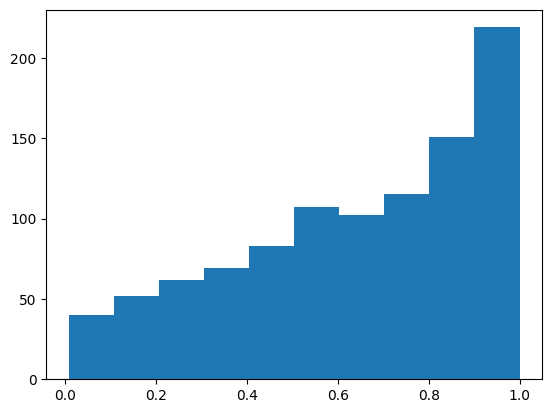

In [608]:
w_beta_true = np.random.uniform(0, 1, 6)

mu_true = logit_fun(np.hstack((scale(X), np.ones((n, 1)))).dot(w_beta_true))
phi_true = 3

y_beta = np.random.beta(mu_true * phi_true, (1 - mu_true) * phi_true)

print(y_beta.min(), y_beta.max())
plt.hist(y_beta, bins=10)
plt.show()

И применим к этим данным бета-регрессию:

In [609]:
X_beta_train, X_beta_test, y_beta_train, y_beta_test = train_test_split(
    X, y_beta, test_size=0.25, random_state=42
)

In [610]:
beta_reg_model = SGDBetaRegressor(
    StoperPoint(1e-5, max_step=1000), alpha=1e-2, batch_size=64
)
beta_reg_model = beta_reg_model.fit(X_beta_train, y_beta_train)
print(w_beta_true)
print(beta_reg_model.W, beta_reg_model.phi)
print(beta_reg_model.grad_desc.stoper.k)
y_beta_pred_model = beta_reg_model.predict(X_beta_test)
print(
    root_mean_squared_error(
        y_beta_test,
        y_beta_pred_model,
        sample_weight=(1 + beta_reg_model.phi)
        / (y_beta_pred_model * (1 - y_beta_pred_model)),
    )
)
print(
    BIC(
        log_likelyhood_beta,
        np.hstack((beta_reg_model.phi, beta_reg_model.W)),
        X_beta_test,
        y_beta_test,
    )
)

[0.16823658 0.18993474 0.46071217 0.28627986 0.24746298 0.64523764]
[0.17352431 0.17595637 0.48424675 0.28510756 0.22701474 0.60908208] 2.869650965716117
1000
0.23641016916129623
-104.95906430298052


In [611]:
beta_reg_mod_model = BetaModel(
    y_beta_train,
    np.hstack((np.array(X_beta_train), np.ones((X_beta_train.shape[0], 1)))),
    link_precision=Identity(),
)
beta_reg_mod_model = beta_reg_mod_model.fit()
print(beta_reg_mod_model.summary())

y_beta_pred_mod_model = beta_reg_mod_model.predict(
    np.hstack((np.array(X_beta_test), np.ones((X_beta_test.shape[0], 1))))
)
print(
    root_mean_squared_error(
        y_beta_test,
        y_beta_pred_mod_model,
        sample_weight=(1 + beta_reg_mod_model.params[-1])
        / (y_beta_pred_mod_model * (1 - y_beta_pred_mod_model)),
    )
)
print(
    BIC(
        log_likelyhood_beta,
        np.hstack(
            (
                beta_reg_mod_model.params[-1],
                beta_reg_mod_model.params[:-1],
            )
        ),
        X_beta_test,
        y_beta_test,
    )
)

                              BetaModel Results                               
Dep. Variable:                      y   Log-Likelihood:                 233.37
Model:                      BetaModel   AIC:                            -452.7
Method:            Maximum Likelihood   BIC:                            -420.4
Date:                Sat, 14 Dec 2024                                         
Time:                        19:17:10                                         
No. Observations:                 750                                         
Df Residuals:                     743                                         
Df Model:                           5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1355      0.037      3.665      0.000       0.063       0.208
x2             0.1540      0.036      4.228      0.0

Алгоритм из пакета дал самую лучшую оценку.

Рассмотим теперь реальные данные:

In [612]:
beta_data = pd.read_csv("observations.csv", sep=";")
beta_data = beta_data.drop(columns="Cover_class")
target_column = "Cover"
features_columns = beta_data.drop(columns=target_column).columns

beta_data["Cover"] = beta_data["Cover"] / 100

beta_data.head()

,Site_id,Visit_id,Species_id,Cover
0,4,6345,2338,0.02
1,4,16199,2338,0.03
2,4,28382,2338,0.03
3,4,40703,2338,0.02
4,4,49283,2338,0.01


Посмотрим на расперделения таргета:

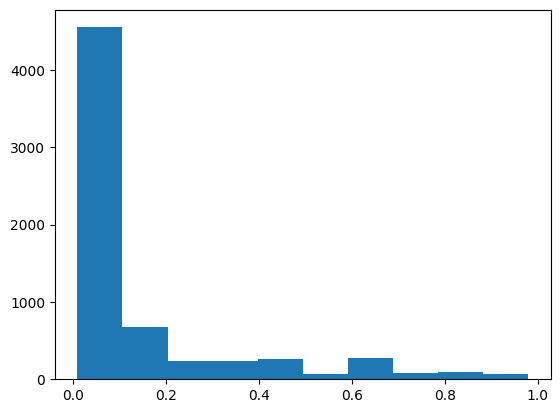

In [613]:
plt.hist(beta_data[target_column], bins=10)
plt.show()

Близко к равномерному, хотя вполне возможно, что слева есть небольшое увеличение количества.

Разделим на трейн и тест:

In [614]:
beta_data_train, beta_data_test, target_train, target_test = train_test_split(
    beta_data[features_columns],
    beta_data[target_column],
    test_size=0.25,
    random_state=42,
)

Начнём с линейной регрессии. Посмотрим, может, будет неплохо:

In [615]:
reg_b = SGDLinearRegressor(StoperPoint(max_step=1000), alpha=1e-3, batch_size=64)
reg_b = reg_b.fit(beta_data_train, target_train)
print(reg_b.W)
y_pred_b = reg_b.predict(beta_data_test)
print(root_mean_squared_error(target_test, y_pred_b))
print(
    1
    - (1 - r2_score(target_test, y_pred_b))
    * (len(target_test) - 1)
    / (len(target_test) - beta_data_test.shape[1] - 1)
)
print(BIC(log_likelyhood_simple, reg_b.W, beta_data_test, target_test))

[-0.01029629  0.00390969 -0.07444774  0.14781972]
0.19821878571462667
0.08052169877750748
34333.96781939073


In [616]:
reg_lr_b = LinearRegression()
reg_lr_b = reg_lr_b.fit(beta_data_train, target_train)
print(np.hstack((reg_lr_b.coef_, reg_lr_b.intercept_)))
y_pred_lr_b = reg_lr_b.predict(beta_data_test)
print(root_mean_squared_error(target_test, y_pred_lr_b))
print(
    1
    - (1 - r2_score(target_test, y_pred_lr_b))
    * (len(target_test) - 1)
    / (len(target_test) - beta_data_test.shape[1] - 1)
)
print(
    BIC(
        log_likelyhood_simple,
        np.hstack((reg_lr_b.coef_, reg_lr_b.intercept_)),
        beta_data_test,
        target_test,
    )
)

[ 2.17298850e-07  2.08623308e-08 -6.67397081e-05  1.77966213e-01]
0.19704179867874827
0.09140866936931613
32405.112904250727


Судя по отрицательному значению поправленного $R ^2$ линейная модель здесь не очень хороша.

Применим нашу бета-регрессию к данным и посмотрим на весовой RMSE и BIC:

In [617]:
beta_reg = SGDBetaRegressor(
    StoperPoint(1e-5, max_step=1000), alpha=1e-2, batch_size=100
)
beta_reg = beta_reg.fit(beta_data_train, target_train)
print(beta_reg.W)
print(beta_reg.phi)
y_pred_beta = beta_reg.predict(beta_data_test)
print(
    root_mean_squared_error(
        target_test,
        y_pred_beta,
        sample_weight=(1 + beta_reg.phi) / (y_pred_beta * (1 - y_pred_beta)),
    )
)
print(
    BIC(
        log_likelyhood_beta,
        np.hstack((beta_reg.phi, beta_reg.W)),
        beta_data_test,
        target_test,
    )
)

[ 0.02943923 -0.02372326 -0.23218236 -1.73620955]
3.205425959739417
0.19112065352431074
-3449.8922908760874


Судя по RMSE результат не очень, так как можно сказать, что мы ошибаемся в среднем на $30 \%$, что много. А по BIC мы сможем сравнить с пакетом `statsmodels`:

In [618]:
beta_reg_mod = BetaModel(
    target_train,
    np.hstack((np.array(beta_data_train), np.ones((beta_data_train.shape[0], 1)))),
    link_precision=Identity(),
)
beta_reg_mod = beta_reg_mod.fit()
print(beta_reg_mod.summary())

y_pred_mod = beta_reg_mod.predict(
    np.hstack((np.array(beta_data_test), np.ones((beta_data_test.shape[0], 1))))
)
print(
    root_mean_squared_error(
        target_test,
        y_pred_mod,
        sample_weight=(1 + beta_reg_mod.params["precision"])
        / (y_pred_mod * (1 - y_pred_mod)),
    )
)
print(
    BIC(
        log_likelyhood_beta,
        np.hstack((beta_reg_mod.params["precision"], beta_reg_mod.params[:-1])),
        beta_data_test,
        target_test,
    )
)

                              BetaModel Results                               
Dep. Variable:                  Cover   Log-Likelihood:                 5218.6
Model:                      BetaModel   AIC:                        -1.043e+04
Method:            Maximum Likelihood   BIC:                        -1.039e+04
Date:                Sat, 14 Dec 2024                                         
Time:                        19:17:12                                         
No. Observations:                4909                                         
Df Residuals:                    4904                                         
Df Model:                           3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          5.766e-07   3.96e-06      0.146      0.884   -7.18e-06    8.33e-06
x2         -3.904e-08   7.12e-07     -0.055      0.9

С точки зрения RMSE алгоритмы примерно равны, но вот по BIC наша модель показала себя даже лучше.